In [1]:
import os
os.chdir("../../")

In [2]:
import flax
from flax import linen as nn
from flax.core import unfreeze

import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import seaborn as sns
import distrax
from datasets import sin_data
import tensorflow_probability.substrates.jax as tfp

from models.gaussian_mlp import gmlp 
from models.mlp import mlp 
from utilities.fits import fit
from utilities.gmm import gmm_mean_var
from utilities.predict import predict

In [3]:
X, y, x_test_1, y_test_1, x_test_2, y_test_2 = sin_data.load_data()

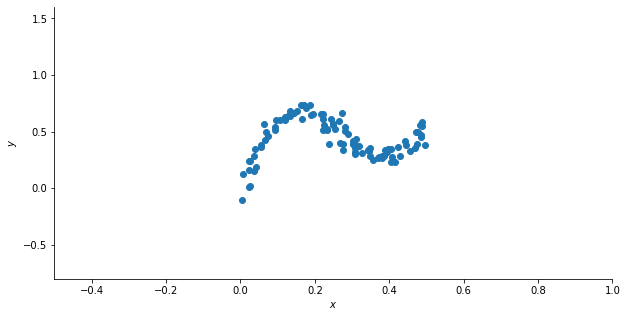

In [4]:
plt.figure(figsize=(10,5))
plt.scatter(X,y)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.5, 1.0)
plt.ylim(-0.8, 1.6)
sns.despine()
plt.show()

## MLP

In [5]:
mlp_model = mlp([32, 32, 1],[nn.relu,nn.relu],[0,0])

In [6]:
# mlp_model.tabulate(jax.random.PRNGKey(0), X, deterministic=True)

In [7]:
mlp_params = mlp_model.init(jax.random.PRNGKey(0), X, True)

In [8]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [9]:
mlp_params, mlp_loss = fit(mlp_model, mlp_params, auxs, learning_rate= 0.01, epochs=2000, verbose=True)

Loss step 0:  0.12494419
Loss step 200:  0.0025141798
Loss step 400:  0.0020413573
Loss step 600:  0.001956073
Loss step 800:  0.0019488148
Loss step 1000:  0.0019542254
Loss step 1200:  0.0019491157
Loss step 1400:  0.0019507693
Loss step 1600:  0.0019474978
Loss step 1800:  0.0019397404


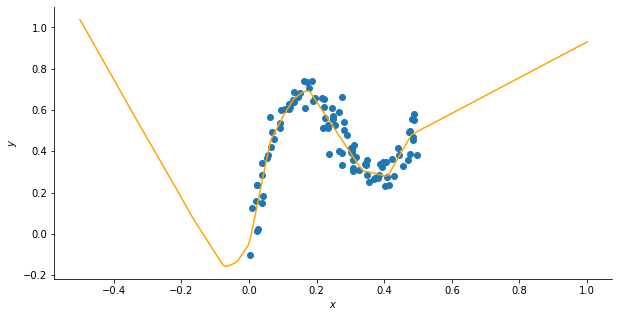

In [10]:
x = jnp.linspace(-0.5, 1, 200).reshape(-1,1)
y_hat = mlp_model.apply(mlp_params, x, True)
plt.figure(figsize=(10,5))
plt.scatter(X, y)
plt.plot(x, y_hat, color="orange")
plt.xlabel("$x$")
plt.ylabel("$y$")
sns.despine()
plt.show()

Gaussian MLP

In [11]:
gmlp_model = gmlp(features=[32, 32], activations=[nn.elu, nn.elu], dropout_rate=[0.01, 0.01])

In [12]:
# gmlp_model.tabulate(jax.random.PRNGKey(0), X, deterministic=True)

In [13]:
gmlp_params = gmlp_model.init(jax.random.PRNGKey(0), X, True)

In [14]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [15]:
gmlp_params, loss = fit(gmlp_model, gmlp_params, auxs, learning_rate=0.01, epochs=2000, verbose=True)

Loss step 0:  0.79700667
Loss step 200:  -0.5072815
Loss step 400:  -1.0675529
Loss step 600:  -1.2991439
Loss step 800:  -1.2962358
Loss step 1000:  -1.3463975
Loss step 1200:  -1.3627515
Loss step 1400:  -1.3839741
Loss step 1600:  -1.3951699
Loss step 1800:  -1.4132456


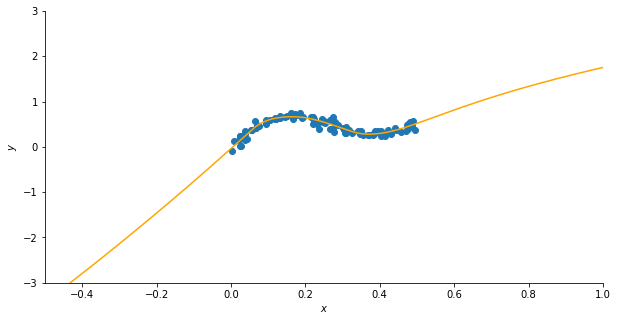

In [16]:
x = jnp.linspace(-0.5, 1, 200).reshape(-1,1)
gmlp_mean, gmlp_sigma = gmlp_model.apply(gmlp_params, x, True)
plt.figure(figsize=(10,5))
plt.scatter(X, y)
plt.plot(x, gmlp_mean, color="orange")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.5, 1.0)
plt.ylim(-3,3)
sns.despine()
plt.show()


## MC Dropout Gaussian MLP

In [17]:
x = jnp.linspace(-0.5, 1, 200).reshape(-1,1)
n_stacks = 100

fn = lambda i : gmlp_model.apply(gmlp_params, x, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)})
y_stacks = jax.vmap(fn, in_axes=(0))(jnp.arange(n_stacks))
mean_stacks = y_stacks[0]
sigma_stacks = y_stacks[1]

In [18]:
mc_mean, mc_sigma = gmm_mean_var(mean_stacks, sigma_stacks)

In [19]:
# plt.figure(figsize=(10,7))
# plt.scatter(X, y, c="g")
# plt.scatter(x_test_1, y_test_1, c="b")
# plt.scatter(x_test_2, y_test_2, c="b")
# plt.plot(x, mc_mean, color="red", label = f"$ \mu $")

# for i in range(1,4):
#     plt.fill_between(x.squeeze(), mc_mean - i*mc_sigma, mc_mean + i*mc_sigma, color="orange", alpha = 1/(i*3), label = f"$\mu \pm {i}*\sigma$")
# plt.legend(bbox_to_anchor=(1.4,1), fontsize=20)
# sns.despine()
# plt.xlabel("X",fontsize=16)
# plt.ylabel("y",fontsize=16)
# plt.xlim(-0.5, 1.0)
# plt.ylim(-3,3)
# # plt.savefig("guassin_mlp_dropout1.pdf",bbox_inches="tight")

## Deep Ensemble Gaussian MLP

In [20]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [21]:
params_list = []
losses_list = []
n_models = 5

for i in range(5):
    params = gmlp_model.init(jax.random.PRNGKey(i), auxs['X'], deterministic = True)
    params, loss =  fit(gmlp_model, params, auxs, learning_rate=0.003, epochs=2000, verbose=False)
    params_list.append(params)
    losses_list.append(loss)


In [22]:
x = jnp.linspace(-0.5, 1, 200).reshape(-1,1)
means_list,sigmas_list = predict(n_models, gmlp_model, params_list, x)
de_mean, de_sigma = gmm_mean_var(means_list,sigmas_list)

In [23]:
# plt.figure(figsize=(10,7))
# plt.scatter(X, y, c="g")
# plt.scatter(x_test_1, y_test_1, c="b")
# plt.scatter(x_test_2, y_test_2, c="b")
# plt.plot(x, de_mean, color="red", label = f"$ \mu $")

# for i in range(1,4):
#     plt.fill_between(x.squeeze(), de_mean - i*de_sigma, de_mean + i*de_sigma, color="orange", alpha = 1/(i*3), label = f"$\mu \pm {i}*\sigma$")
# plt.legend(bbox_to_anchor=(1.4,1), fontsize=20)
# sns.despine()
# plt.xlabel("X",fontsize=16)
# plt.ylabel("y",fontsize=16)
# plt.xlim(-0.5, 1.0)
# plt.ylim(-3,3)
# # plt.savefig("guassin_mlp_dropout1.pdf",bbox_inches="tight")

In [24]:
def plot(ax, x, mean, sigma):
    # plt.figure(figsize=(10,7))
    ax.scatter(X, y, c="g")
    ax.scatter(x_test_1, y_test_1, c="b")
    ax.scatter(x_test_2, y_test_2, c="b")
    ax.plot(x, mean, color="red", label = f"$ \mu $")

    for i in range(1,4):
        ax.fill_between(x.squeeze(), mean - i*sigma, mean + i*sigma, color="orange", alpha = 1/(i*3), label = f"$\mu \pm {i}*\sigma$")
    ax.legend()
    sns.despine()
    ax.set_xlabel("X",fontsize=16)
    ax.set_ylabel("y",fontsize=16)
    ax.set_xlim(-0.5, 1.0)
    ax.set_ylim(-3,3)

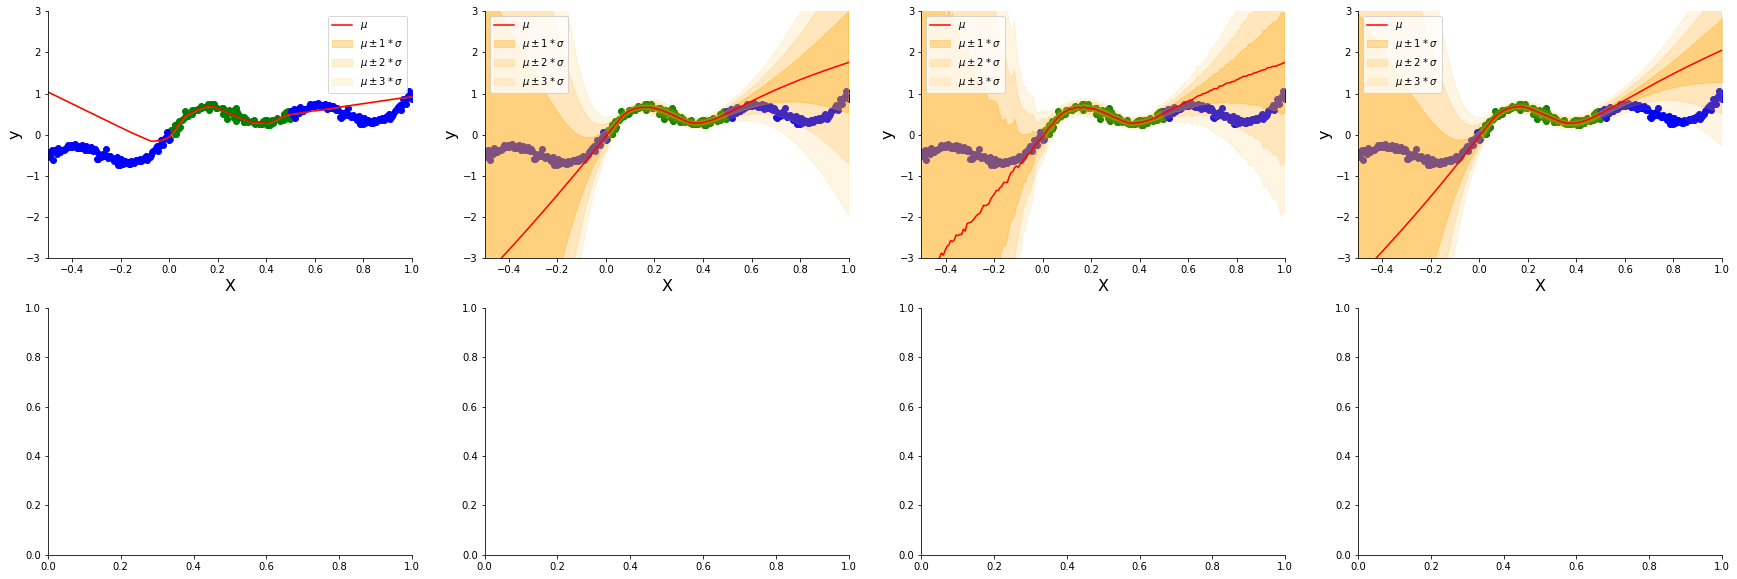

In [25]:
fig, ax = plt.subplots(2, 4, figsize=(30, 10))

plot(ax[0][0], x, y_hat.squeeze(), jnp.array([0]*200))
plot(ax[0][1], x, gmlp_mean, gmlp_sigma)
plot(ax[0][2], x, mc_mean, mc_sigma)
plot(ax[0][3], x, de_mean, de_sigma)